In [58]:
import pandas as pd
import numpy as np
import seaborn as sns

from scipy import stats

In [5]:
CSV_FILEPATH = "traffic.csv"

df = pd.read_csv(CSV_FILEPATH)

In [6]:
df.shape

(226278, 9)

In [7]:
df.head()

,event,date,country,city,artist,album,track,isrc,linkid
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8


## Question 1
**How many total pageview events did the links in the provided dataset receive in the full period, how many per day?**

*To print each unique value of the event column, alongside a count of its occurrences, we can use the value_counts() method. The output for the pageview events is 142,015, so that is our total number of such events. Another solution for it would be to filter the data set to contain only the pageview events and then to read the number of rows in the filtered data set (second cell below).*

In [8]:
# the data set records three types of events: pageview, click, preview
df["event"].value_counts()

event
pageview    142015
click        55732
preview      28531
Name: count, dtype: int64

In [9]:
# the total pageview events is the number of rows where 'event' = 'pageview'
df[df["event"] == "pageview"].shape[0]

142015

Getting the number of pageview events per day requires the application of the groupby method, followed by an aggregate (count) function.

We group the pageview events by the date and then count their occurrence.

In [10]:
# 1. filter only for 'pageview' events
# 2. group by the date
# 3. keep only the 'event' column, and specify a 'count' aggregation
df[df["event"] == "pageview"].groupby(by="date")["event"].count()

date
2021-08-19    22366
2021-08-20    21382
2021-08-21    21349
2021-08-22    20430
2021-08-23    18646
2021-08-24    18693
2021-08-25    19149
Name: event, dtype: int64

Please note that we allow for duplicates in the data, i.e., if the same user views the same page multiple times, it will be counted each time. We can use df.drop_duplicates() to modify this behaviour and see the difference. The following cells illustrate the difference in the data caused after deduplicating: the number of events lowers by nearly half.

In [11]:
df_deduplicated = df.drop_duplicates()

In [12]:
df_deduplicated["event"].value_counts()

event
pageview    73360
click       32499
preview     16708
Name: count, dtype: int64

In [13]:
df_deduplicated[df_deduplicated["event"] == "pageview"].shape[0]

73360

In [14]:
df_deduplicated[df_deduplicated["event"] == "pageview"].groupby(by="date")["event"].count()

date
2021-08-19    13006
2021-08-20    11088
2021-08-21     9939
2021-08-22     9982
2021-08-23     9722
2021-08-24     9705
2021-08-25     9918
Name: event, dtype: int64

## Question 2
**What about the other recorded events?**

*In the first line in the cell below we obtain the set of all unique events in the data. Then, we remove the pageview event because it was already analysed in the previous question. We will deal with whatever events remain.*

In [15]:
# get the set of recorded events in the data
recorded_events = set(df["event"].unique())
# remove the 'pageview' event
recorded_events.remove("pageview")
recorded_events

{'click', 'preview'}

Once we have the other recorded events, we can simply loop over them and apply the same solution from Question 1, adding some informative print statements in the process.

In [16]:
# loop over each event
for recorded_event in recorded_events:
    # get the total number of occurrences
    total_events = df[df["event"] == recorded_event].shape[0]
    print("Total number of", recorded_event, "events is", total_events, "\n")
    # group by the date and aggregate by count
    data_set = df[df["event"] == recorded_event].groupby(by="date")["event"].count()
    print(recorded_event, "event distribution per day:\n")
    print(data_set, "\n")

Total number of preview events is 28531 

preview event distribution per day:

date
2021-08-19    3788
2021-08-20    4222
2021-08-21    4663
2021-08-22    4349
2021-08-23    3847
2021-08-24    3840
2021-08-25    3822
Name: event, dtype: int64 

Total number of click events is 55732 

click event distribution per day:

date
2021-08-19    9207
2021-08-20    8508
2021-08-21    8071
2021-08-22    7854
2021-08-23    7315
2021-08-24    7301
2021-08-25    7476
Name: event, dtype: int64 



## Question 3
**Which countries did the clicks come from?**

This question is a bit simpler than the ones before, in the sense that it does not require any groupings or aggregations. The solution consists of two steps:

1. We need to filter for the click events only
2. We can print the unique values of the Country column (ignoring any nans)

In [17]:
# filter for the proper event
df_q3 = df[df["event"] == "click"]
# or alternatively, you can loop over the array provided by df.unique() and print them all
pd.DataFrame(data=df_q3["country"].dropna().unique(), columns=["Country"])

,Country
0,Saudi Arabia
1,India
2,France
3,Maldives
4,United States
...,...
197,Guernsey
198,Palau
199,Åland
200,Principality of Monaco


## Question 4

**What was the overall click rate (clicks/pageviews)?**

The click rate is the number of clicks that a page has received (event = 'click') divided by the number of times it has been shown (event = 'pageview'). It is a commonly used metric that measures the success of an advertising campaign.

Its calculation requires a few steps.

To start with, we can count the number of times each link has been clicked on, and the number of times each link has been viewed. The same procedure applies to both calculations. We first filter for the proper event (click or pageview), then we group the filtered data by the link Id and count the occurrences of that event.

In [18]:
# filter only 'click' events and group them by the 'linkid' to get their count,
# i.e., number of clicks on each link
link_clicks = df[df["event"] == "click"].groupby(by="linkid")["event"].count().reset_index()
link_clicks = link_clicks.rename(columns={
    "event": "clicks" # rename column for easier manipulation
})
# do the same for the 'pageview' events
pageviews = df[df["event"] == "pageview"].groupby(by="linkid")["event"].count().reset_index()
pageviews = pageviews.rename(columns={
    "event": "pageviews"
})

In [22]:
link_clicks.sort_values("clicks", ascending=False)

,linkid,clicks
428,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692
2058,e849515b-929d-44c8-a505-e7622f1827e9,2198
754,522da5cc-8177-4140-97a7-a84fdb4caf1c,2109
951,681d888a-59ce-4acb-b7c5-95dab0c063d9,1500
1739,c2c876ab-b093-4750-9449-6b4913da6af3,1429
...,...,...
933,66039cfc-95e4-5465-9f74-92fe985f0c51,1
932,65f96010-b7e4-5a1a-ad68-1d3dac083072,1
931,65ed6dd2-6453-51ab-96c0-4ea6118999be,1
930,65d45131-ec44-5adc-9d19-70186d27067f,1


In [27]:
pageviews.sort_values("pageviews", ascending=False)

,linkid,pageviews
709,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,25175
1250,522da5cc-8177-4140-97a7-a84fdb4caf1c,6600
3475,e849515b-929d-44c8-a505-e7622f1827e9,5981
2949,c2c876ab-b093-4750-9449-6b4913da6af3,4303
537,23199824-9cf5-4b98-942a-34965c3b0cc2,3532
...,...,...
2157,8c646478-fdc9-5410-89cd-15385794cf84,1
2158,8c71ba08-d449-521e-8092-5d4f7e14d759,1
2159,8c7849a7-cb1f-5482-ae81-043546086f2e,1
2160,8c7dce2a-58e7-5811-bb78-5233939247a4,1


To get the answer, we need to somehow join these two Dataframes on the same link Id, and then divide the number of clicks by the number of pageviews to get the required click rate. It can be achieved with Pandas' merge() method. We specify a 'left' and a 'right' Dataframe, a column to merge on, and how the merge should go (we specify 'inner' which takes the intersection of the two data sets).

In [28]:
# pd.merge() does a database-style join of the two dataframes
df_q4 = pd.merge(left=link_clicks, right=pageviews, on="linkid", how="inner")

In [29]:
# define a new column of the 'click_rate'
df_q4["click_rate"] = df_q4["clicks"] / df_q4["pageviews"]

Once we do the merge, we can do column-wise arithmetics to produce a new column that would store the click rate. The cell below prints the final data set, providing us with the click rate for each link.

In [31]:
df_q4.sort_values("click_rate", ascending=False)

,linkid,clicks,pageviews,click_rate
1789,c95f1fc1-fab0-4c74-b3f5-52bd3684a713,923,10,92.300000
470,330773a6-f22a-5c7a-a3e4-7809fe8539b9,3,1,3.000000
371,27a91fe1-9fc0-5c28-9e9e-19ff0e7357a7,3,1,3.000000
1739,c2d99bb2-6ea3-568c-80d3-44dc36250cbc,2,1,2.000000
172,132c744a-d87b-5ed6-aff2-d9b8c718a4ea,2,1,2.000000
...,...,...,...,...
1136,7cf99126-2092-4b29-bdf9-a2f8ad5500ed,1,8,0.125000
1009,6e6c1939-9d37-450e-aec1-2af09140bc33,1,11,0.090909
1004,6dacffe9-779d-4e9b-94dd-a3e811b2983e,1,11,0.090909
324,229f278b-f052-57e7-813d-15d25f226723,1,11,0.090909


## Question 5

**How does the clickrate distribute across different links?**

To get a sense of the distribution of the click rate across different links, we can use the describe() method. The cell below does that. Observe the output. We have the count (number of links), the mean, standard deviation, min, max, as well as the value of the click rate at the 25, 50, and 75th percentile.

In [33]:
df_q4["click_rate"].describe()

count    2253.000000
mean        0.809920
std         1.958030
min         0.090909
25%         0.500000
50%         1.000000
75%         1.000000
max        92.300000
Name: click_rate, dtype: float64

Tabular data can only give us so much, so we can try to plot the data and visualize some insights.

Using the plot() method we plot a histogram with 100 bins. Notice how we provide parameters for the figure size and the label of the X-axis. It is always a good idea to have these as they provide make the interpretation of the graphic a lot easier.

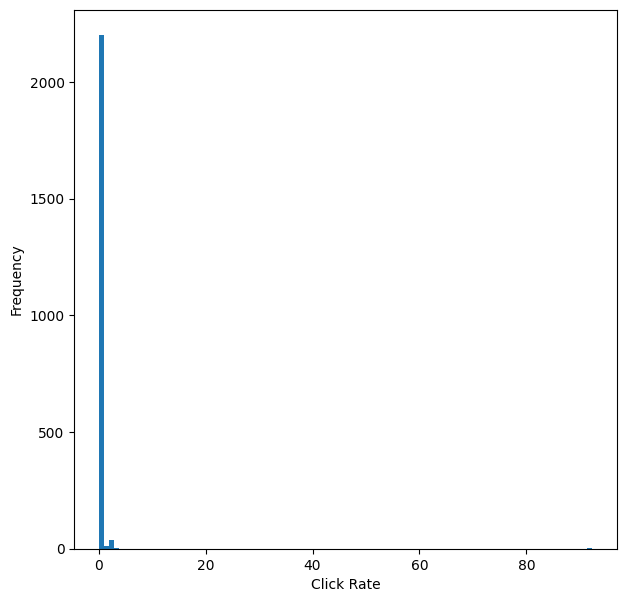

In [34]:
ax = df_q4["click_rate"].plot(kind="hist", figsize=(7, 7), bins=100)
_ = ax.set_xlabel("Click Rate")

The histogram shows that the data is highly skewed to left, i.e., many of its values are very close to zero. In such cases, a common workaround is to plot the histogram of the logarithm of the data. Let us try that, we can use Numpy's log2() method for it!

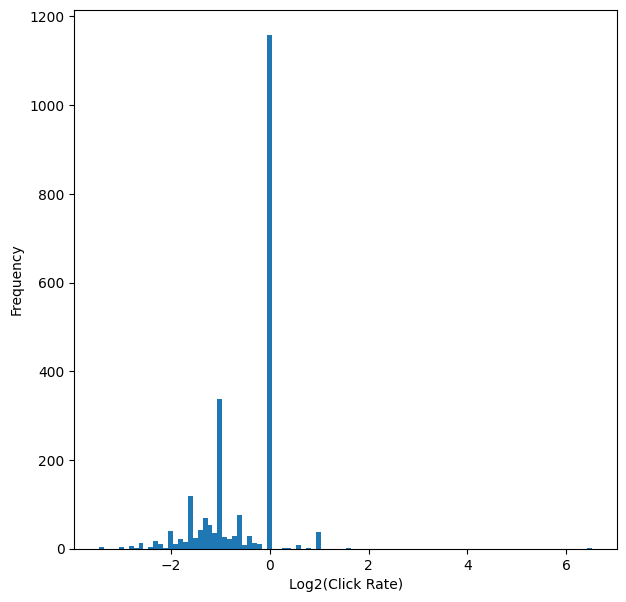

In [35]:
# because the data is highly skewed, it makes more sense to plot the log of it
df_q4["click_rate_log2"] = np.log2(df_q4["click_rate"])
ax = df_q4["click_rate_log2"].plot(kind="hist", figsize=(7, 7), bins=100)
_ = ax.set_xlabel("Log2(Click Rate)")

We observe an enormous spike at the 0 meaning that the actual click rate was 1, implying that there are many links that have been viewed and clicked on exactly once. There are also, many links that have been viewed many times but clicked on fewer (values less than zero). Remember, this plots the logarithm of the actual values, so there is an extra math step in the interpretation here.

One last thing to try is a box plot, which is basically a visualization of the describe() method.

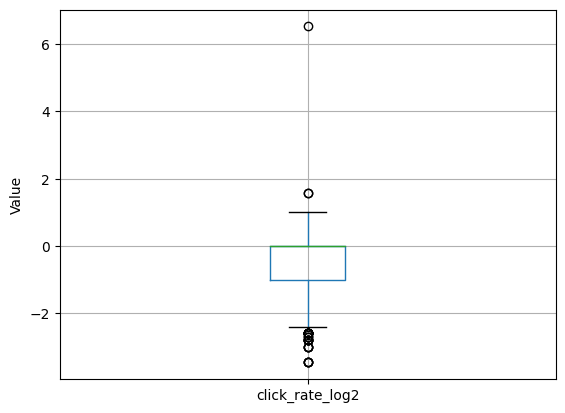

In [36]:
ax = df_q4.boxplot(column="click_rate_log2")
_ = ax.set_ylabel("Value")

We observe two (and one particular) high outliers, and many, many below the Q1 (i.e., click rate very close to zero). Our guess is that there are at least two links, that have been clicked on multiple times in the same page view.

## Question 6

**Is there any correlation between clicks and previews on a link? Is it significant? How large is the effect? Make sure to at least test for potential linear as well as categorical (think binary) relationships between both variables.**

Pearson's correlation coefficient is a measure of linear correlation between two data sets. It takes its value in the range of [-1, 1] and the further it is from zero, the more significant the correlation is.

Pearson's coefficient is implemented in both Pandas and Scipy, and here we are actually going to use both libraries, just to explore their APIs and to compare results! (should be the same).

First, let us filter the data to contain only the click and the preview events. We can describe it to get a sense of the contents.

In [37]:
# filter only events that are relevant to the question
df_q6 = df[df["event"].isin(["click", "preview"])]

In [38]:
df_q6.describe()

,event,date,country,city,artist,album,track,isrc,linkid
count,84263,84263,84261,84261,84252,84262,84262,82036,84263
unique,2,7,206,8137,1549,2003,2155,628,2286
top,click,2021-08-19,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8
freq,55732,12995,18461,8893,15666,15666,15666,15666,15666


Now, we just repeat the same procedure as in Question 4. We create two new columns and append them to the original data.

In [39]:
# filter only 'click' events and group them by the 'linkid' to get their count,
# i.e., number of clicks on each link
link_clicks = df[df["event"] == "click"].groupby(by="linkid")["event"].count().reset_index()
link_clicks = link_clicks.rename(columns={
    "event": "clicks" # rename column for easier manipulation
})
# do the same for the 'preview' events
previews = df[df["event"] == "preview"].groupby(by="linkid")["event"].count().reset_index()
previews = previews.rename(columns={
    "event": "previews"
})

In [40]:
# perform two database-style joins to append the 
# number of link clicks and previews to each row
df_q6 = pd.merge(left=df_q6, right=link_clicks, how="left", on="linkid")
df_q6 = pd.merge(left=df_q6, right=previews, how="left", on="linkid")

In [43]:
df_q6.dropna(subset=["clicks", "previews"], inplace=True)
df_q6

,event,date,country,city,artist,album,track,isrc,linkid,clicks,previews
0,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
1,click,2021-08-21,Saudi Arabia,Jeddah,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
2,click,2021-08-21,India,Ludhiana,Reyanna Maria,So Pretty,So Pretty,USUM72100871,23199824-9cf5-4b98-942a-34965c3b0cc2,1187.0,718.0
3,click,2021-08-21,France,Unknown,"Simone & Simaria, Sebastian Yatra",No Llores Más,No Llores Más,BRUM72003904,35573248-4e49-47c7-af80-08a960fa74cd,69.0,30.0
4,click,2021-08-21,Maldives,Malé,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
...,...,...,...,...,...,...,...,...,...,...,...
84258,preview,2021-08-23,United States,Brentwood,Tesher,Jalebi Baby,Jalebi Baby,QZNWQ2070741,2d896d31-97b6-4869-967b-1c5fb9cd4bb8,9692.0,5974.0
84259,preview,2021-08-23,Saudi Arabia,Riyadh,Evanescence,Fallen,Bring Me To Life,USWU30200093,0ea9f8bf-a144-42bd-a7b0-124e73914da4,20.0,14.0
84260,preview,2021-08-23,Ukraine,Kyiv,Miscél,when you left,when you left,QM42K1907890,2fc15e8b-83aa-40ee-9f9d-5d96c6d4356c,235.0,145.0
84261,preview,2021-08-23,Saudi Arabia,Khamis Mushait,Anne-Marie,Beautiful,Beautiful,GBAHS2100225,522da5cc-8177-4140-97a7-a84fdb4caf1c,2109.0,1605.0


Finally, we calculate the correlation coefficient with both pandas and scipy.

In [45]:
df_q6.corr()

ValueError: could not convert string to float: 'click'

In [46]:
df_q6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79438 entries, 0 to 84262
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   event     79438 non-null  object 
 1   date      79438 non-null  object 
 2   country   79436 non-null  object 
 3   city      79436 non-null  object 
 4   artist    79438 non-null  object 
 5   album     79438 non-null  object 
 6   track     79438 non-null  object 
 7   isrc      79438 non-null  object 
 8   linkid    79438 non-null  object 
 9   clicks    79438 non-null  float64
 10  previews  79438 non-null  float64
dtypes: float64(2), object(9)
memory usage: 7.3+ MB


In [51]:
df_q6["clicks"] = df_q6["clicks"].astype(float)

In [52]:
df_q6["previews"] = df_q6["previews"].astype(float)

In [53]:
df_q6.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79438 entries, 0 to 84262
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   event     79438 non-null  object 
 1   date      79438 non-null  object 
 2   country   79436 non-null  object 
 3   city      79436 non-null  object 
 4   artist    79438 non-null  object 
 5   album     79438 non-null  object 
 6   track     79438 non-null  object 
 7   isrc      79438 non-null  object 
 8   linkid    79438 non-null  object 
 9   clicks    79438 non-null  float64
 10  previews  79438 non-null  float64
dtypes: float64(2), object(9)
memory usage: 7.3+ MB


In [55]:
df_q6[['clicks', 'previews']].corr()

,clicks,previews
clicks,1.000000,0.998713
previews,0.998713,1.000000


In [56]:
stats.pearsonr(x=df_q6["clicks"], y=df_q6["previews"])

PearsonRResult(statistic=0.998712507200853, pvalue=0.0)

Almost perfectly positive correlation between the number of clicks and previews which seems logical; given that the one is actually dependent on the other (can't have clicks without previews and vice versa).

Using pd.factorize() we can quantify the relationship between categorical variables in similar manner as with numerical variables.

In [57]:
categorical_columns = [
    "country",
    "city",
    "artist",
    "album",
    "track"
]
factorized_df = df_q6[categorical_columns] \
                     .apply(lambda x: pd.factorize(x)[0]) \
                     .corr()
factorized_df

,country,city,artist,album,track
country,1.000000,0.189353,0.018565,0.023316,0.024796
city,0.189353,1.000000,0.103752,0.108283,0.111936
artist,0.018565,0.103752,1.000000,0.946371,0.949177
album,0.023316,0.108283,0.946371,1.000000,0.976958
track,0.024796,0.111936,0.949177,0.976958,1.000000


We observe a high positive correlation between album, artist, and track and almost no correlation between other variables. This is again expected, since those variables are naturally dependent, i.e., each track belongs to an album and is performed by an artist.

**Tambahan**

<Axes: >

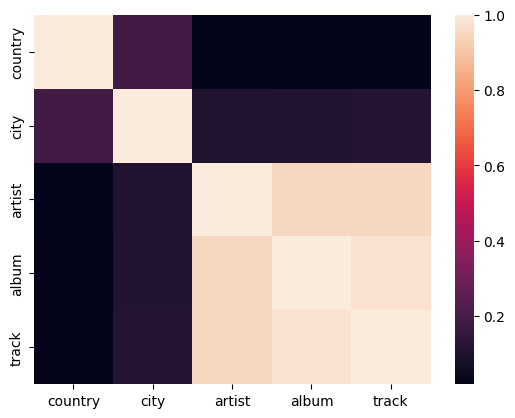

In [59]:
sns.heatmap(factorized_df)